# Implementing VAR in PyMC3

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
import pymc3 as pm
import theano.tensor as tt

In [3]:
import matplotlib.pyplot as plt
import arviz as az

In [4]:
import pymc3.distributions.transforms as tr

# Generate VAR

In [5]:
from regime_switching.generate import chain, ar

In [6]:
T = 100
n_endog = 2
n_lag_endog = 1

# n_exog = 0

In [7]:
vg = ar.VARXGenerator.get_random_instance(endog=n_endog, lag_endog=n_lag_endog)
vg

VARXGenerator with params:
  <xarray.Dataset>
  Dimensions:          (endog: 2, exog: 0, lag_endog: 1, lag_exog: 0, target: 2)
  Coordinates:
    * lag_exog         (lag_exog) int64 
    * lag_endog        (lag_endog) int64 1
    * endog            (endog) int64 0 1
    * target           (target) int64 0 1
    * exog             (exog) int64 
  Data variables:
      coef_ar          (target, endog, lag_endog) float64 0.6535 ... -0.1425
      coef_exog        (target, exog, lag_exog) float64 
      coef_covariance  (target, endog) float64 0.2055 0.133 0.133 0.3022
      coef_const       (target) float64 -0.5266 0.8621

In [8]:
data = vg.generate(T)
data

<xarray.Dataset>
Dimensions:  (target: 2, time: 100)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * target   (target) int64 0 1
Data variables:
    output   (time, target) float64 -0.6894 1.399 -1.012 ... -2.005 0.1707

# Internals of `logp`

## Coefficient shapes

In [9]:
# Using ACTUAL parameter values here, but shapes will be same for pymc3 params

t_const = tt.as_tensor(vg.coef_const.values)
t_ar = tt.as_tensor(vg.coef_ar.values)
t_cov = tt.as_tensor(vg.coef_covariance.values)

# NOTE: Initial values not currently set in VARXGenerator
t_init = tt.as_tensor(np.full(shape=(n_lag_endog, n_endog), fill_value=0))

print(
    "const:", t_const.shape.eval(), "==", (n_endog,),
    "\nar:", t_ar.shape.eval(), "==", (n_endog, n_endog, n_lag_endog),
    "\ncov:", t_cov.shape.eval(), "==", (n_endog, n_endog),
    "\ninit:", t_init.shape.eval(), "==", (n_lag_endog, n_endog),
)

const: [2] == (2,) 
ar: [2 2 1] == (2, 2, 1) 
cov: [2 2] == (2, 2) 
init: [1 2] == (1, 2)


## Pad the data

In [10]:
t_data = tt.as_tensor(data['output'].values)
t_data_pre = tt.concatenate([t_init, t_data], axis=0)
print(
    "data:", t_data.shape.eval(), "==", (T, n_endog),
    "\npadded:", t_data_pre.shape.eval(), "==", (n_lag_endog + T, n_endog)
)

data: [100   2] == (100, 2) 
padded: [101   2] == (101, 2)


## Get expected mean

In [11]:
# Sum up total AR effect
effect_ar = []
for i in range(n_lag_endog):
    # lag is i+1
    _start = n_lag_endog - (i + 1)
    _end = -(i + 1)
    q = tt.dot(t_data_pre[_start:_end, :], t_ar[:, :, i])
    effect_ar.append(q)
effect_ar = tt.add(*effect_ar)
effect_ar.shape.eval()  # == (T, n_endog)

array([100,   2])

In [12]:
expected_mean = effect_ar + t_const[None, :]
errors = t_data - expected_mean
errors.shape.eval()  # == (T, n_endog)

array([100,   2])

## Find likelihood

In [13]:
dist_innov = pm.MvNormal.dist(mu=0, **{"cov": t_cov})

like_innov = dist_innov.logp(errors)
like_innov.shape.eval()  # == (T, )

array([100])

In [14]:
dist_init = pm.Flat.dist()
# dist_init = pm.Normal.dist(mu=0, sigma=10, shape=[2])

like_init = dist_init.logp(t_init)  # == (n_lag_endog, n_endog)?
like_init.shape.eval()  # == (n_lag_endog, n_endog) ?

array([1, 2])

In [15]:
like_total = tt.sum(like_init) + tt.sum(like_innov)
like_total.shape.eval()  # == tuple()

array([], dtype=int64)

# Create class

In [16]:
# pm.distributions.continuous.get_tau_sigma

In [17]:
# Using ACTUAL parameter values here, but shapes will be same for pymc3 params

t_const = tt.as_tensor(vg.coef_const.values)
t_ar = tt.as_tensor(vg.coef_ar.values)
t_cov = tt.as_tensor(vg.coef_covariance.values)

# NOTE: Initial values not currently set in VARXGenerator
t_init = tt.as_tensor(np.full(shape=(n_lag_endog, n_endog), fill_value=0))

print(
    "const:", t_const.shape.eval(), "==", (n_endog,),
    "\nar:", t_ar.shape.eval(), "==", (n_endog, n_endog, n_lag_endog),
    "\ncov:", t_cov.shape.eval(), "==", (n_endog, n_endog),
    "\ninit:", t_init.shape.eval(), "==", (n_lag_endog, n_endog),
)

const: [2] == (2,) 
ar: [2 2 1] == (2, 2, 1) 
cov: [2 2] == (2, 2) 
init: [1 2] == (1, 2)


In [69]:
class VAR(pm.Continuous):
    
    def __init__(
        self, 
        n_endog, n_lag_endog, 
        t_const, t_init, t_ar,
        cov=None, tau=None, chol=None, lower=True,
        dist_init=pm.Flat.dist(), 
        *args, **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.n_endog = int(n_endog)
        self.n_lag_endog = int(n_lag_endog)

        self.t_const = tt.as_tensor_variable(t_const)
        self.t_init = tt.as_tensor_variable(t_init)
        self.t_ar = tt.as_tensor_variable(t_ar)
        
        # Covariance distribution args for innovation process
        # TODO: Maybe allow non-MvNormal innovation dist?
        self.cov_args = dict(cov=cov, tau=tau, chol=chol, lower=lower)
        
        # Distribution for initial values - default is Flat a.k.a. "no idea" 
        self.dist_init = dist_init
        
        # Test value
        self.mean = tt.as_tensor_variable(np.zeros(shape=(n_endog,)))
        
    def logp(self, value: tt.Tensor) -> tt.TensorVariable:
        """f"""
        
        # Prepend initial values
        t_data = tt.as_tensor(value)
        try:
            t_data_pre = tt.concatenate([self.t_init, t_data], axis=0)
        except Exception:
            t_data_pre = self.t_init
        
        # Sum up total AR effect
        effect_ar = []
        for i in range(n_lag_endog):
            # lag is i+1
            _start = n_lag_endog - (i + 1)
            _end = -(i + 1)
            q = tt.dot(t_data_pre[_start:_end, :], self.t_ar[:, :, i])
            effect_ar.append(q)
        effect_ar = tt.add(*effect_ar)
        # effect_ar.shape.eval()  # == (T, n_endog)
        
        # Add constant to get errors
        expected_mean = effect_ar + self.t_const[None, :]
        errors = t_data - expected_mean
        # errors.shape.eval()  # == (T, n_endog)
        
        # Get likelihoods
        dist_innov = pm.MvNormal.dist(mu=0, **self.cov_args)
        like_innov = dist_innov.logp(errors)
        # like_innov.shape.eval()  # == (T, )
        
        dist_init = self.dist_init
        like_init = dist_init.logp(t_init)  # == (n_lag_endog, n_endog)?
        # like_init.shape.eval()  # == (n_lag_endog, n_endog) ?
        
        like_total = tt.sum(like_init) + tt.sum(like_innov)
        # like_total.shape.eval()  # == tuple()
        
        return like_total

In [70]:
# VAR.dist(n_endog=n_endog, n_lag_endog=n_lag_endog).logp(data['output'].values)

## Test in model

### Build model

In [71]:
import warnings

warnings.simplefilter('ignore', FutureWarning)

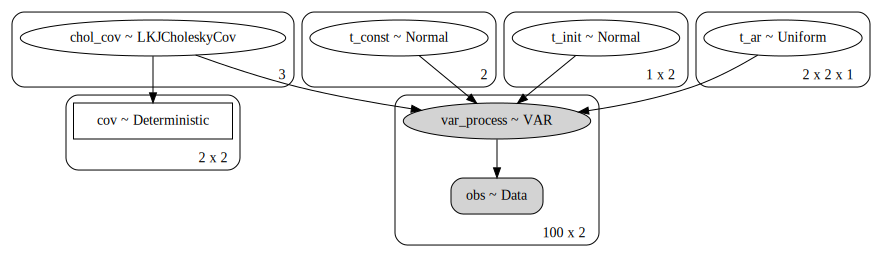

In [72]:
with pm.Model() as m:
    sd_dist = pm.HalfCauchy.dist(beta=2.5)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=n_endog, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(n_endog, packed_chol, lower=True)
    
    cov = pm.Deterministic('cov', tt.dot(chol, chol.T))
    
    pm.Normal('t_const', 0, 1, shape=(n_endog,))
    pm.Normal('t_init', 0, 10, shape=(n_lag_endog, n_endog))
    pm.Uniform('t_ar', -1, 1, shape=(n_endog, n_endog, n_lag_endog))
    
    obs = pm.Data('obs', data['output'].values)
    var = VAR(
        'var_process', 
        n_endog=n_endog, n_lag_endog=n_lag_endog, 
        t_const=m['t_const'], 
        t_init=m['t_init'],
        t_ar=m['t_ar'],
        chol=chol, 
        observed=m['obs'],
    )
    
pm.model_to_graphviz(m)

### Fit

In [73]:
with m:
    trace = pm.sample(draws=1000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [t_ar, t_init, t_const, chol_cov]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [06:30<00:00, 15.35draws/s] 


### Check traces

In [74]:
ifd = az.from_pymc3(trace=trace)

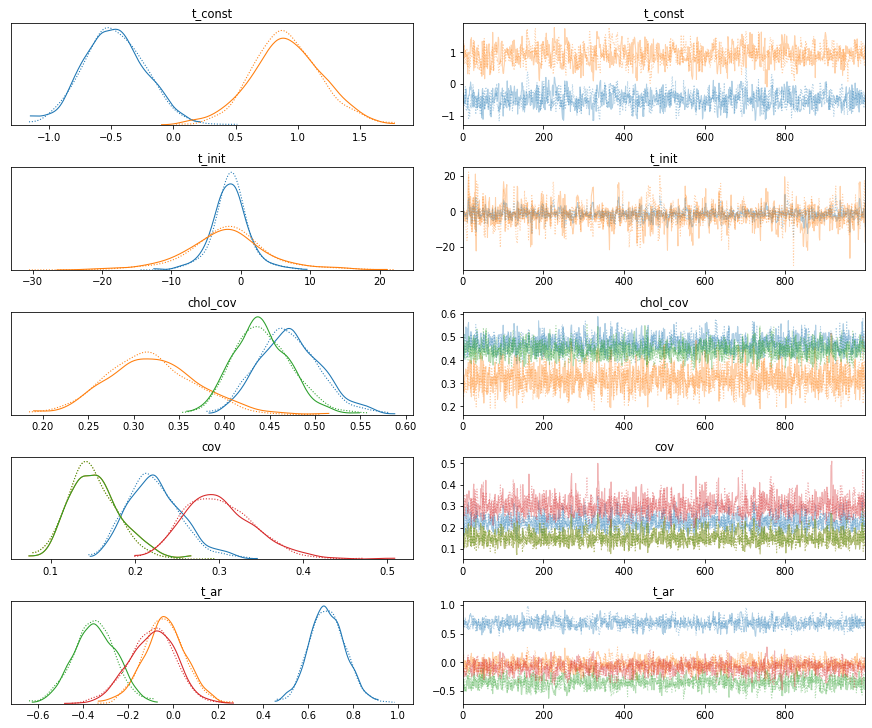

In [75]:
pm.traceplot(trace);

### Compare with actual values

In [76]:
# Estimated covariance matrix
ifd.posterior['cov'].mean(dim=['chain', 'draw']).values

array([[0.22390848, 0.15159301],
       [0.15159301, 0.3008683 ]])

In [77]:
# Actual covariance matrix
vg.coef_covariance.values

array([[0.20546543, 0.13300602],
       [0.13300602, 0.30224644]])

In [78]:
# Estimated constant term
ifd.posterior['t_const'].mean(dim=['chain', 'draw']).values

array([-0.47700567,  0.91216622])

In [79]:
vg.coef_const.values

array([-0.52663137,  0.86209397])

In [82]:
# Estimated constant term
ifd.posterior['t_ar'].mean(dim=['chain', 'draw']).values

array([[[ 0.68585026],
        [-0.03782901]],

       [[-0.34969272],
        [-0.09399357]]])

In [83]:
vg.coef_ar.values

array([[[ 0.65345897],
        [-0.36774077]],

       [[-0.08177358],
        [-0.14250454]]])

In [80]:
# Estimated initial values
ifd.posterior['t_init'].mean(dim=['chain', 'draw']).values

array([[-1.47315703, -2.01043949]])

In [81]:
# None for vg, yet - is TODO